# 2D FFT Pipeline for Processed Images  

This notebook runs a 2D Fourier transform over the processed grayscale stack used by PaperDRM to explore the dominant spatial frequencies across the acquisition.

1. Load the centralised settings + processed images.
2. Visualise a sample frame and its log-spectrum to understand the per-frame frequency content.
3. Aggregate across the stack to reveal population-level frequency energy.
4. Extract a radial profile of the average power spectrum to capture anisotropy in spatial frequencies.

In [3]:
import numpy as np
from matplotlib import pyplot as plt

from paperdrm import ImagePack, Settings

settings = Settings.from_yaml("exp_param.yaml").with_overrides(angle_slice=(2, 2))
pack = ImagePack(settings=settings)
image_stack = np.stack(pack.images, axis=0)
mean_image = image_stack.mean(axis=0)
print(f"Loaded {len(pack.images)} images of shape {mean_image.shape} (HxW)")

loading images: 100%|██████████| 480/480 [00:01<00:00, 299.09it/s]


Loaded 120 images of shape (2160, 4096) (HxW)


### Sample frame frequency content
Compare a representative frame to its log-frequency image so the dominant spatial wavelengths become clear while the log scale keeps the zero-frequency energy visible.

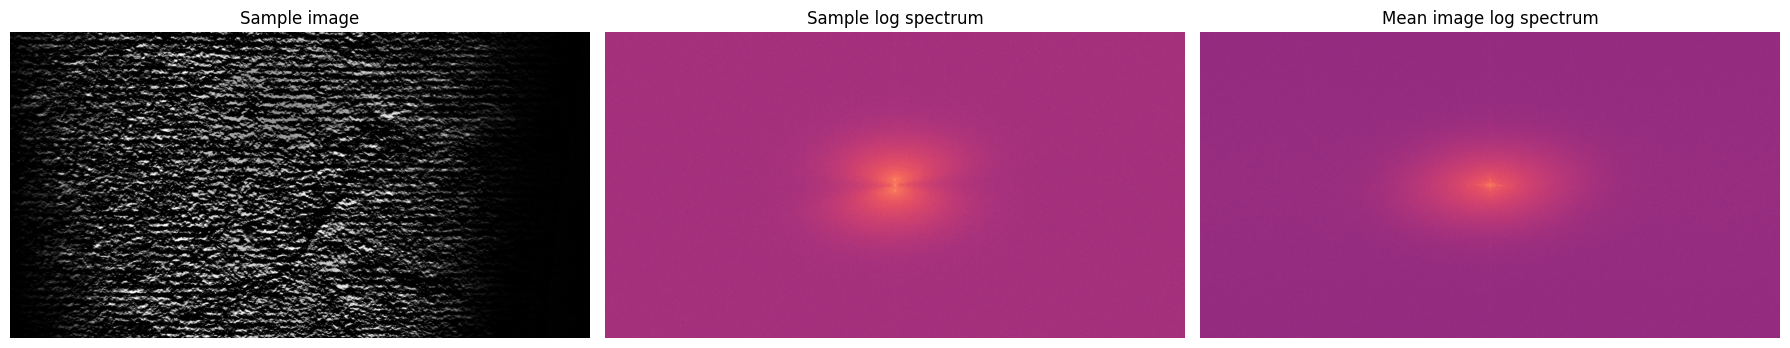

In [4]:
def log_spectrum(image: np.ndarray) -> np.ndarray:
    spectrum = np.fft.fftshift(np.fft.fft2(image))
    return np.log1p(np.abs(spectrum))

sample_idx = len(image_stack) // 2
sample_image = image_stack[sample_idx]
sample_spectrum = log_spectrum(sample_image)
mean_spectrum = log_spectrum(mean_image)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].imshow(sample_image, cmap="gray")
axes[0].set_title("Sample image")
axes[1].imshow(sample_spectrum, cmap="magma")
axes[1].set_title("Sample log spectrum")
axes[2].imshow(mean_spectrum, cmap="magma")
axes[2].set_title("Mean image log spectrum")
for ax in axes:
    ax.axis("off")
plt.tight_layout()

#### Dominant frequency & orientation
Highlight the strongest non-zero frequency bin to understand the prevalent scale and its direction in the sample frame.

Dominant spectrum radius: 38.0 px, orientation: 90.0° relative to horizontal


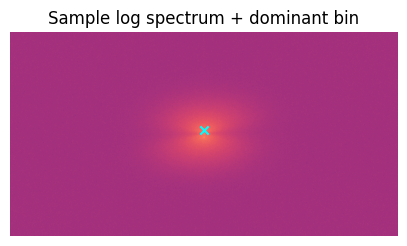

In [5]:
power = np.abs(np.fft.fftshift(np.fft.fft2(sample_image))) ** 2
center = np.array(power.shape) // 2
mask = np.zeros_like(power, dtype=bool)
mask[center[0]-2:center[0]+3, center[1]-2:center[1]+3] = True
power_masked = power.copy()
power_masked[mask] = 0
peak = np.unravel_index(np.argmax(power_masked), power_masked.shape)
dy = peak[0] - center[0]
dx = peak[1] - center[1]
freq_radius = np.hypot(dy, dx)
angle_deg = (np.degrees(np.arctan2(dy, dx)) + 180) % 180
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(sample_spectrum, cmap="magma")
ax.scatter([peak[1]], [peak[0]], color="cyan", marker="x")
ax.set_title("Sample log spectrum + dominant bin")
ax.axis("off")
print(f"Dominant spectrum radius: {freq_radius:.1f} px, orientation: {angle_deg:.1f}° relative to horizontal")

#### FFT-based line overlay
Draw the original sample frame with lines spaced by the dominant spatial period and rotated to the detected orientation so the FFT peak maps directly onto the image texture.

Overlay spacing ~107.8 px at 90.0°


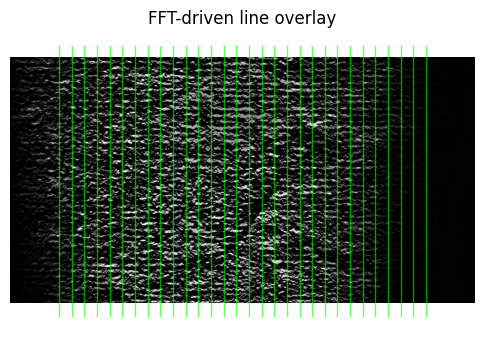

In [7]:
angle_rad = np.radians(angle_deg)
h, w = sample_image.shape
line_len = min(h, w) * 0.55
wavelength = max(h, w) / max(freq_radius, 1e-8)
freq_dir = np.array([np.cos(angle_rad), np.sin(angle_rad)])
line_dir = np.array([-np.sin(angle_rad), np.cos(angle_rad)])
num_lines = min(30, max(6, int(np.ceil(max(h, w) / max(wavelength, 1))) * 2))
offsets = np.linspace(-num_lines / 2 * wavelength, num_lines / 2 * wavelength, num_lines)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(sample_image, cmap="gray")
for offset in offsets:
    center = np.array([w // 2, h // 2]) + freq_dir * offset
    pts = np.stack([
        center - line_dir * line_len,
        center + line_dir * line_len,
    ])
    ax.plot(pts[:, 0], pts[:, 1], color="lime", linewidth=1, alpha=0.6)
ax.set_title("FFT-driven line overlay")
ax.axis("off")
overlay_angle = (angle_deg + 90) % 180
print(f"Overlay spacing ~{wavelength:.1f} px at {overlay_angle:.1f}° (texture direction)")
